**Import and structure the mosquito image dataset**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')
dataset_path = 'gdrive/My Drive/MosquitoNet/featured only'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# import tensorflow and check for gpu
%tensorflow_version 2.x
import tensorflow as tf

# for AlexNet
from tensorflow import keras
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# path to dataset
dataset_path = 'gdrive/My Drive/MosquitoNet/featured only'

# lists to hold all filenames
filenames_headlegs = []
filenames_palps = []
filenames_wings = []

# list to hold all labels
labels = []

# iterate through original dataset folder
root, dirs, _ = next(os.walk(dataset_path))
count = 0
for subdir in dirs:
  count += 1
  root_subdir, _, _ = next(os.walk(os.path.join(root, subdir)))

  # extract label for all images in folder
  fname = os.path.join(root_subdir, 'label.txt')
  with open(fname) as fp:
    label = fp.read().split('\n')[0]
  labels.append(label)

  #  save image filepaths
  fname = os.path.join(root_subdir, 'head-legs.bmp')
  filenames_headlegs.append(fname)

  fname = os.path.join(root_subdir, 'palps.bmp')
  filenames_palps.append(fname)

  fname = os.path.join(root_subdir, 'wings.bmp')
  filenames_wings.append(fname)

print("Total examples:" + str(len(labels)))

Total examples:1327


In [0]:
def import_image(fname):
  # convert image from bitmap to tensor
  image_string = tf.io.read_file(fname)
  image = tf.image.decode_bmp(image_string, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image

In [0]:
# dataset will be a list of dictionaries
dataset = []

# iterate through filenames in dataset, create dictionary of images/label, add to dataset list
for i in range(0,count):
  curr_entry = {}
  curr_entry["label"] = labels[i]
  curr_entry["headlegs"] = import_image(filenames_headlegs[i])
  curr_entry["wings"] = import_image(filenames_wings[i])
  curr_entry["palps"] = import_image(filenames_palps[i])
  dataset.append(curr_entry)
  sys.stdout.write("\rAdded %i files" % i)

Added 1326 files

In [0]:
import pickle

# save the dataset dictionary structure using pickle
filename = 'gdrive/My Drive/MosquitoNet/mosquito_dataset.pkl'
outfile = open(filename,'wb')
pickle.dump(dataset,outfile)
outfile.close()

In [0]:
# START RUNNING HERE - also import everything!
import pickle 

# uncomment to import with pickle
filename = 'gdrive/My Drive/MosquitoNet/mosquito_dataset.pkl'
infile = open(filename,'rb')
dataset = pickle.load(infile)
infile.close()

**AlexNet model for MNIST (verification)**

In [17]:
import cv2

# load fashion_mnist dataset
fashion_mnist = tf.keras.datasets.fashion_mnist

# (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # customary normalization to [0, 1]

# because we're using CNNs, the data needs a channel dimension:
x_train = x_train[..., None]
x_test = x_test[..., None]

# reshape to 224x224
# x_train.reshape((x_train.shape[0], 224, 224, 1))
# x_test.reshape((x_test.shape[0], 224, 224, 1))
# for i in range(len(x_train)):
#   x_train[i] = np.asarray(x_train[i])
#   x_train[i] = cv2.reshape(x_train[i], (224, 224, 1))

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28, 1, 1) (60000,)
(10000, 28, 28, 1, 1) (10000,)


In [0]:
# define AlexNet as keras sequential model
# ref: https://medium.com/datadriveninvestor/cnn-architecture-series-alexnet-with-implementation-part-ii-7f7afa2ac66a

n_classes = 1

model = keras.models.Sequential([
    # conv layer 1
    Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding="valid", activation = "relu"),    # input shape for MNIST is different, change strides cause getting negative dimensions?
    MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"),

    # conv layer 2
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding="same", activation = "relu"),
    MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"),

    # added batchnorm
    BatchNormalization(),

    # conv layer 3
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"),

    # conv layer 4
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"),
    
    # conv layer 5
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"),
    MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"),

    # added batchnorm
    BatchNormalization(),

    # dense layers
    Flatten(),
    Dense(units = 9216, activation = "relu"),
    Dense(units = 4096, activation = "relu"),
    Dense(4096, activation = "relu"),

    # output
    Dense(n_classes, activation = "softmax")
])

In [11]:
# configure the learning process
model.compile(
    # define optimizer and set learning rate
    optimizer=keras.optimizers.Adam(),

    # choose a loss function
    loss=keras.losses.CategoricalCrossentropy(),

    # choose a metric to report
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 9, 9, 96)          11712     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 96)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 256)         614656    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 3, 3, 256)         1024      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 3, 384)         885120    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 3, 384)        

In [12]:
h = model.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0000e+00 - accuracy: 0.1000 - val_loss: 0.0000e+00 - val_accuracy: 0.1000
Epoch 2/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0000e+00 - accuracy: 0.1000 - val_loss: 0.0000e+00 - val_accuracy: 0.1000
Epoch 3/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0000e+00 - accuracy: 0.1000 - val_loss: 0.0000e+00 - val_accuracy: 0.1000
Epoch 4/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0000e+00 - accuracy: 0.1000 - val_loss: 0.0000e+00 - val_accuracy: 0.1000
Epoch 5/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0000e+00 - accuracy: 0.1000 - val_loss: 0.0000e+00 - val_accuracy: 0.1000
Epoch 6/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0000e+00 - accuracy: 0.1000 - val_loss: 0.0000e+00 - val_accuracy: 0.1000
Epoch 7/10
1875/1875 [==============================] - 25s 13ms/step - loss

In [0]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

model.summary()

**AlexNet model**

In [0]:
# define AlexNet as keras sequential model
# ref: https://medium.com/datadriveninvestor/cnn-architecture-series-alexnet-with-implementation-part-ii-7f7afa2ac66a

n_classes = 4

model = keras.models.Sequential([
    # conv layer 1
    Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding="valid", activation = "relu"),
    MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"),

    # conv layer 2
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding="same", activation = "relu"),
    MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"),

    # added batchnorm
    BatchNormalization(),

    # conv layer 3
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"),

    # conv layer 4
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"),
    
    # conv layer 5
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"),
    MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"),

    # added batchnorm
    BatchNormalization(),

    # dense layers
    Flatten(),
    Dense(units = 9216, activation = "relu"),
    Dense(units = 4096, activation = "relu"),
    Dense(4096, activation = "relu"),

    # output
    Dense(n_classes, activation = "softmax")
])

In [0]:
# configure the learning process
model.compile(
    # define optimizer and set learning rate
    optimizer=keras.optimizers.Adam(),

    # choose a loss function
    loss=keras.losses.CategoricalCrossentropy(),

    # choose a metric to report
    metrics=['accuracy']
)

**Subset headlegs images from dataset**

In [28]:
# extract headlegs images from dictionary
x_full = [np.array(example["palps"]) for example in dataset]
# x_full.extend([np.array(example["wings"]) for example in dataset])
# x_full.extend([np.array(example["palps"]) for example in dataset])
y_full = [np.array(example["label"]) for example in dataset]
# y_full.extend([np.array(example["label"]) for example in dataset])
# y_full.extend([np.array(example["label"]) for example in dataset])

# create splits
from  sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.2, shuffle=True, random_state=0)

# convert to numpy array
x_train = np.array([np.array(el) for el in x_train])
x_test = np.array([np.array(el) for el in x_test])
y_train = np.array([np.array(el) for el in y_train])
y_test = np.array([np.array(el) for el in y_test])

# print summary
print('x_full: ' + str(len(x_full)) + ' samples, type: ' + str(type(x_full)))
print('y_full: ' + str(len(y_full)) + ' samples, type: ' + str(type(y_full)))
print('x_train: ' + str(len(x_train)) + ' samples, shape: ' + str(x_train.shape))
print('y_train: ' + str(len(y_train)) + ' samples, shape: ' + str(y_train.shape))
print('x_test: ' + str(len(x_test)) + ' samples, shape: ' + str(x_test.shape))
print('y_test: ' + str(len(y_test)) + ' samples, shape: ' + str(y_test.shape))

x_full: 1327 samples, type: <class 'list'>
y_full: 1327 samples, type: <class 'list'>
x_train: 1061 samples, shape: (1061, 224, 224, 3)
y_train: 1061 samples, shape: (1061,)
x_test: 266 samples, shape: (266, 224, 224, 3)
y_test: 266 samples, shape: (266,)


**Train AlexNet**

In [0]:
# preprocess dataset with keras
import tensorflow.keras

# create one-hot label vectors
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
y_train_onehot = onehotencoder.fit_transform(y_train.reshape(-1,1)).toarray()
y_test_onehot = onehotencoder.fit_transform(y_test.reshape(-1,1)).toarray()


# create ImageDataGenerator instances for train & test
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    horizontal_flip=True,
    vertical_flip=True,
    height_shift_range=0.2,
    width_shift_range=0.2
)

test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    horizontal_flip=True,
    vertical_flip=True,
    height_shift_range=0.2,
    width_shift_range=0.2
)


In [68]:
# training parameters
BATCH_SIZE = 32
STEPS_PER_EPOCH = np.ceil(len(x_train) / BATCH_SIZE)
EPOCHS = 30

# create generators
train_generator = train_datagen.flow(x_train, y_train_onehot, batch_size=BATCH_SIZE)
test_generator = test_datagen.flow(x_test, y_test_onehot, batch_size=BATCH_SIZE)

# train model - only headlegs (no pre-processing)
history_headlegs = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_generator,
    validation_steps=np.ceil(len(x_test)/BATCH_SIZE)
)

Epoch 1/30
34/34 [==============================] - 4s 120ms/step - loss: 6.2645 - accuracy: 0.4025 - val_loss: 40.4695 - val_accuracy: 0.4211
Epoch 2/30
34/34 [==============================] - 4s 112ms/step - loss: 1.3157 - accuracy: 0.4307 - val_loss: 9.0275 - val_accuracy: 0.4286
Epoch 3/30
34/34 [==============================] - 4s 112ms/step - loss: 1.2702 - accuracy: 0.4496 - val_loss: 2.6955 - val_accuracy: 0.4286
Epoch 4/30
34/34 [==============================] - 4s 112ms/step - loss: 1.2689 - accuracy: 0.4260 - val_loss: 5.8398 - val_accuracy: 0.4135
Epoch 5/30
34/34 [==============================] - 4s 112ms/step - loss: 1.2590 - accuracy: 0.4241 - val_loss: 3.0998 - val_accuracy: 0.4023
Epoch 6/30
34/34 [==============================] - 4s 112ms/step - loss: 1.2585 - accuracy: 0.4524 - val_loss: 1.4643 - val_accuracy: 0.4060
Epoch 7/30
34/34 [==============================] - 4s 112ms/step - loss: 1.2602 - accuracy: 0.4430 - val_loss: 1.4387 - val_accuracy: 0.4248
Epoch

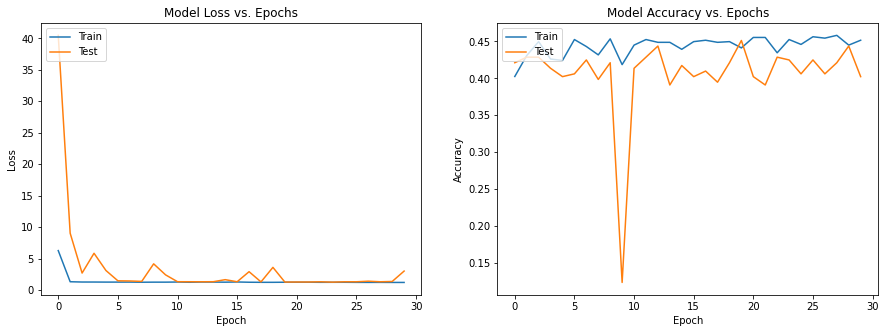

In [88]:
# visualize training - only headlegs (no preprocessing)
plt.figure(figsize=(15,5))

# plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_headlegs.history['loss'])
plt.plot(history_headlegs.history['val_loss'])
plt.title('Model Loss vs. Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history_headlegs.history['accuracy'])
plt.plot(history_headlegs.history['val_accuracy'])
plt.title('Model Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# show plot
plt.savefig('gdrive/My Drive/MosquitoNet/figures/headlegs.png')
plt.show()

In [74]:
# training parameters
BATCH_SIZE = 32
STEPS_PER_EPOCH = np.ceil(len(x_train) / BATCH_SIZE)
EPOCHS = 30

# create generators
train_generator = train_datagen.flow(x_train, y_train_onehot, batch_size=BATCH_SIZE)
test_generator = test_datagen.flow(x_test, y_test_onehot, batch_size=BATCH_SIZE)

# train model - only wings (no preprocessing)
history_wings = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_generator,
    validation_steps=np.ceil(len(x_test)/BATCH_SIZE)
)

Epoch 1/30
34/34 [==============================] - 4s 119ms/step - loss: 6.2492 - accuracy: 0.3940 - val_loss: 4.6049 - val_accuracy: 0.4211
Epoch 2/30
34/34 [==============================] - 4s 112ms/step - loss: 1.2731 - accuracy: 0.4354 - val_loss: 1.8940 - val_accuracy: 0.3947
Epoch 3/30
34/34 [==============================] - 4s 112ms/step - loss: 1.2577 - accuracy: 0.4439 - val_loss: 1.2515 - val_accuracy: 0.4586
Epoch 4/30
34/34 [==============================] - 4s 112ms/step - loss: 1.2707 - accuracy: 0.4288 - val_loss: 1.7397 - val_accuracy: 0.4323
Epoch 5/30
34/34 [==============================] - 4s 112ms/step - loss: 1.2686 - accuracy: 0.4467 - val_loss: 1.3699 - val_accuracy: 0.3534
Epoch 6/30
34/34 [==============================] - 4s 112ms/step - loss: 1.2656 - accuracy: 0.4486 - val_loss: 1.3502 - val_accuracy: 0.4248
Epoch 7/30
34/34 [==============================] - 4s 112ms/step - loss: 1.2436 - accuracy: 0.4392 - val_loss: 1.5546 - val_accuracy: 0.4135
Epoch 

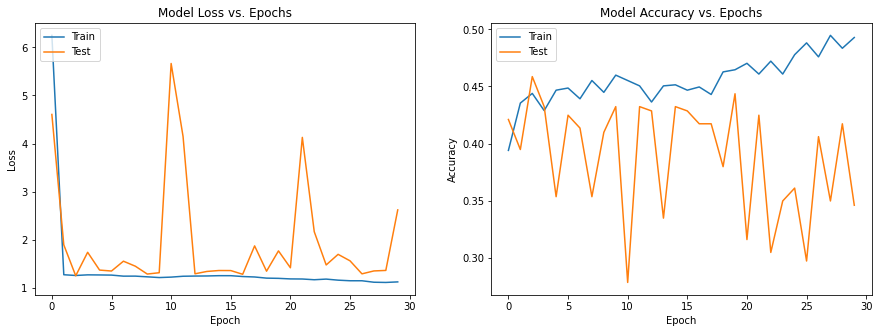

In [89]:
# visualize training - only wings (no preprocessing)
plt.figure(figsize=(15,5))

# plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_wings.history['loss'])
plt.plot(history_wings.history['val_loss'])
plt.title('Model Loss vs. Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history_wings.history['accuracy'])
plt.plot(history_wings.history['val_accuracy'])
plt.title('Model Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# show plot
plt.savefig('gdrive/My Drive/MosquitoNet/figures/wings.png')
plt.show()

In [80]:
# training parameters
BATCH_SIZE = 32
STEPS_PER_EPOCH = np.ceil(len(x_train) / BATCH_SIZE)
EPOCHS = 30

# create generators
train_generator = train_datagen.flow(x_train, y_train_onehot, batch_size=BATCH_SIZE)
test_generator = test_datagen.flow(x_test, y_test_onehot, batch_size=BATCH_SIZE)

# train model - only palps (no preprocessing)
history_palps = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_generator,
    validation_steps=np.ceil(len(x_test)/BATCH_SIZE)
)

Epoch 1/30
34/34 [==============================] - 4s 120ms/step - loss: 5.4592 - accuracy: 0.3930 - val_loss: 4.0192 - val_accuracy: 0.2782
Epoch 2/30
34/34 [==============================] - 4s 112ms/step - loss: 1.2618 - accuracy: 0.4420 - val_loss: 1.9459 - val_accuracy: 0.4286
Epoch 3/30
34/34 [==============================] - 4s 113ms/step - loss: 1.2738 - accuracy: 0.4505 - val_loss: 1.3013 - val_accuracy: 0.4023
Epoch 4/30
34/34 [==============================] - 4s 113ms/step - loss: 1.2809 - accuracy: 0.4006 - val_loss: 1.3192 - val_accuracy: 0.4511
Epoch 5/30
34/34 [==============================] - 4s 113ms/step - loss: 1.2936 - accuracy: 0.4402 - val_loss: 1.3129 - val_accuracy: 0.3947
Epoch 6/30
34/34 [==============================] - 4s 112ms/step - loss: 1.2772 - accuracy: 0.4486 - val_loss: 1.3079 - val_accuracy: 0.4436
Epoch 7/30
34/34 [==============================] - 4s 113ms/step - loss: 1.2769 - accuracy: 0.4420 - val_loss: 1.3684 - val_accuracy: 0.4173
Epoch 

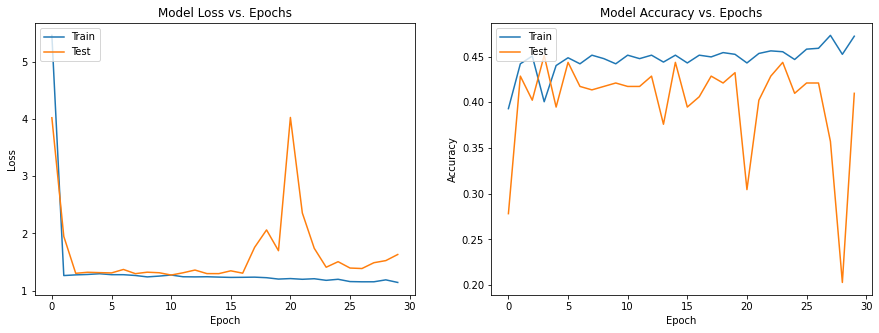

In [90]:
# visualize training - only palps (no preprocessing)
plt.figure(figsize=(15,5))

# plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_palps.history['loss'])
plt.plot(history_palps.history['val_loss'])
plt.title('Model Loss vs. Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history_palps.history['accuracy'])
plt.plot(history_palps.history['val_accuracy'])
plt.title('Model Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# show plot
plt.savefig('gdrive/My Drive/MosquitoNet/figures/palps.png')
plt.show()

In [86]:
# training parameters
BATCH_SIZE = 32
STEPS_PER_EPOCH = np.ceil(len(x_train) / BATCH_SIZE)
EPOCHS = 30

# create generators
train_generator = train_datagen.flow(x_train, y_train_onehot, batch_size=BATCH_SIZE)
test_generator = test_datagen.flow(x_test, y_test_onehot, batch_size=BATCH_SIZE)

# train model - all 3 (no preprocessing)
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_generator,
    validation_steps=np.ceil(len(x_test)/BATCH_SIZE)
)

Epoch 1/30
100/100 [==============================] - 12s 117ms/step - loss: 3.0911 - accuracy: 0.4259 - val_loss: 1.2703 - val_accuracy: 0.4479
Epoch 2/30
100/100 [==============================] - 11s 114ms/step - loss: 1.2843 - accuracy: 0.4391 - val_loss: 1.2752 - val_accuracy: 0.4379
Epoch 3/30
100/100 [==============================] - 11s 114ms/step - loss: 1.2768 - accuracy: 0.4378 - val_loss: 1.2952 - val_accuracy: 0.4517
Epoch 4/30
100/100 [==============================] - 11s 114ms/step - loss: 1.2870 - accuracy: 0.4344 - val_loss: 1.2593 - val_accuracy: 0.4567
Epoch 5/30
100/100 [==============================] - 11s 114ms/step - loss: 1.2694 - accuracy: 0.4444 - val_loss: 1.2786 - val_accuracy: 0.4429
Epoch 6/30
100/100 [==============================] - 12s 115ms/step - loss: 1.2688 - accuracy: 0.4441 - val_loss: 1.2582 - val_accuracy: 0.4467
Epoch 7/30
100/100 [==============================] - 12s 115ms/step - loss: 1.2602 - accuracy: 0.4463 - val_loss: 1.2627 - val_ac

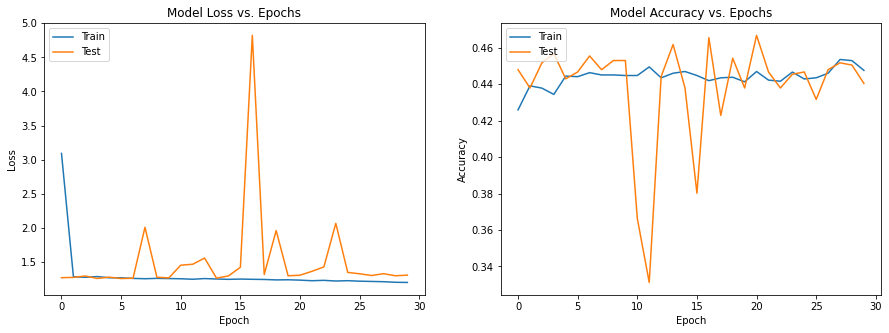

In [91]:
# visualize training - all 3 (no preprocessing)
plt.figure(figsize=(15,5))

# plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss vs. Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# show plot
plt.savefig('gdrive/My Drive/MosquitoNet/figures/all3.png')
plt.show()

Train with preprocessing


In [11]:
# training parameters
BATCH_SIZE = 32
STEPS_PER_EPOCH = np.ceil(len(x_train) / BATCH_SIZE)
EPOCHS = 30

# create generators
train_generator = train_datagen.flow(x_train, y_train_onehot, batch_size=BATCH_SIZE)
test_generator = test_datagen.flow(x_test, y_test_onehot, batch_size=BATCH_SIZE)

# train model - all 3 (with pre-processing)
history_pp = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_generator,
    validation_steps=np.ceil(len(x_test)/BATCH_SIZE)
)

Epoch 1/30
100/100 [==============================] - 45s 446ms/step - loss: 2.4128 - accuracy: 0.4284 - val_loss: 1.3800 - val_accuracy: 0.4479
Epoch 2/30
100/100 [==============================] - 43s 434ms/step - loss: 1.2953 - accuracy: 0.4347 - val_loss: 1.2728 - val_accuracy: 0.4429
Epoch 3/30
100/100 [==============================] - 43s 435ms/step - loss: 1.2757 - accuracy: 0.4410 - val_loss: 1.2942 - val_accuracy: 0.2873
Epoch 4/30
100/100 [==============================] - 43s 434ms/step - loss: 1.2693 - accuracy: 0.4372 - val_loss: 1.2819 - val_accuracy: 0.4417
Epoch 5/30
100/100 [==============================] - 43s 435ms/step - loss: 1.2758 - accuracy: 0.4422 - val_loss: 1.2791 - val_accuracy: 0.4454
Epoch 6/30
100/100 [==============================] - 44s 437ms/step - loss: 1.2667 - accuracy: 0.4438 - val_loss: 1.2456 - val_accuracy: 0.4642
Epoch 7/30
100/100 [==============================] - 44s 436ms/step - loss: 1.2659 - accuracy: 0.4444 - val_loss: 1.3705 - val_ac

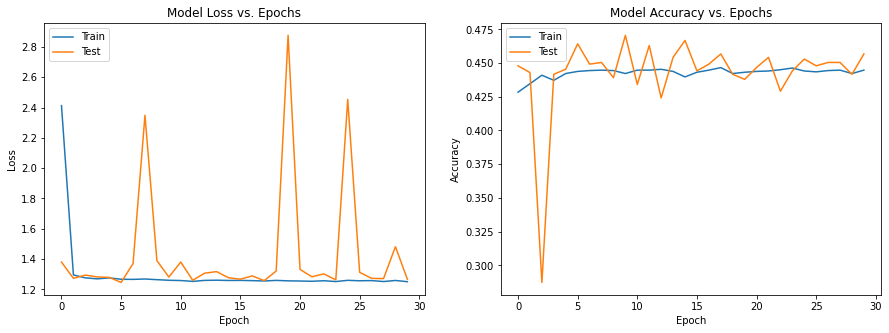

In [13]:
# visualize training - all 3 (no preprocessing)
plt.figure(figsize=(15,5))

# plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_pp.history['loss'])
plt.plot(history_pp.history['val_loss'])
plt.title('Model Loss vs. Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history_pp.history['accuracy'])
plt.plot(history_pp.history['val_accuracy'])
plt.title('Model Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# show plot
plt.savefig('gdrive/My Drive/MosquitoNet/figures/all3_pp.png')
plt.show()

In [18]:
# training parameters
BATCH_SIZE = 32
STEPS_PER_EPOCH = np.ceil(len(x_train) / BATCH_SIZE)
EPOCHS = 30

# create generators
train_generator = train_datagen.flow(x_train, y_train_onehot, batch_size=BATCH_SIZE)
test_generator = test_datagen.flow(x_test, y_test_onehot, batch_size=BATCH_SIZE)

# train model - only headlegs (with pre-processing)
history_headlegs_pp = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_generator,
    validation_steps=np.ceil(len(x_test)/BATCH_SIZE)
)

Epoch 1/30
34/34 [==============================] - 15s 442ms/step - loss: 6.3228 - accuracy: 0.3761 - val_loss: 26.8751 - val_accuracy: 0.4211
Epoch 2/30
34/34 [==============================] - 14s 426ms/step - loss: 1.2899 - accuracy: 0.4345 - val_loss: 5.6954 - val_accuracy: 0.4436
Epoch 3/30
34/34 [==============================] - 15s 427ms/step - loss: 1.2959 - accuracy: 0.4449 - val_loss: 5.5695 - val_accuracy: 0.4323
Epoch 4/30
34/34 [==============================] - 14s 425ms/step - loss: 1.3157 - accuracy: 0.4430 - val_loss: 4.4325 - val_accuracy: 0.3985
Epoch 5/30
34/34 [==============================] - 14s 425ms/step - loss: 1.2978 - accuracy: 0.4298 - val_loss: 6.5097 - val_accuracy: 0.4511
Epoch 6/30
34/34 [==============================] - 15s 427ms/step - loss: 1.3118 - accuracy: 0.4260 - val_loss: 1.3416 - val_accuracy: 0.4023
Epoch 7/30
34/34 [==============================] - 15s 429ms/step - loss: 1.2689 - accuracy: 0.4458 - val_loss: 1.3806 - val_accuracy: 0.345

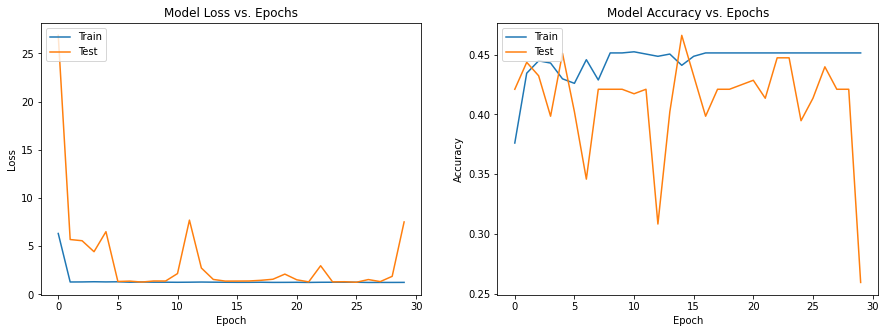

In [19]:
# visualize training - only headlegs (with preprocessing)
plt.figure(figsize=(15,5))

# plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_headlegs_pp.history['loss'])
plt.plot(history_headlegs_pp.history['val_loss'])
plt.title('Model Loss vs. Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history_headlegs_pp.history['accuracy'])
plt.plot(history_headlegs_pp.history['val_accuracy'])
plt.title('Model Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# show plot
plt.savefig('gdrive/My Drive/MosquitoNet/figures/headlegs_pp.png')
plt.show()

In [24]:
# training parameters
BATCH_SIZE = 32
STEPS_PER_EPOCH = np.ceil(len(x_train) / BATCH_SIZE)
EPOCHS = 30

# create generators
train_generator = train_datagen.flow(x_train, y_train_onehot, batch_size=BATCH_SIZE)
test_generator = test_datagen.flow(x_test, y_test_onehot, batch_size=BATCH_SIZE)

# train model - only wings (with pre-processing)
history_wings_pp = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_generator,
    validation_steps=np.ceil(len(x_test)/BATCH_SIZE)
)

Epoch 1/30
34/34 [==============================] - 15s 428ms/step - loss: 6.4072 - accuracy: 0.4006 - val_loss: 1.3452 - val_accuracy: 0.4211
Epoch 2/30
34/34 [==============================] - 14s 425ms/step - loss: 1.2849 - accuracy: 0.4317 - val_loss: 1.4870 - val_accuracy: 0.4023
Epoch 3/30
34/34 [==============================] - 15s 427ms/step - loss: 1.3021 - accuracy: 0.4496 - val_loss: 1.3133 - val_accuracy: 0.4060
Epoch 4/30
34/34 [==============================] - 14s 426ms/step - loss: 1.2765 - accuracy: 0.4373 - val_loss: 1.2584 - val_accuracy: 0.4549
Epoch 5/30
34/34 [==============================] - 14s 425ms/step - loss: 1.2565 - accuracy: 0.4486 - val_loss: 1.6971 - val_accuracy: 0.4211
Epoch 6/30
34/34 [==============================] - 15s 427ms/step - loss: 1.3026 - accuracy: 0.4543 - val_loss: 1.3697 - val_accuracy: 0.3835
Epoch 7/30
34/34 [==============================] - 14s 424ms/step - loss: 1.3034 - accuracy: 0.4496 - val_loss: 1.2685 - val_accuracy: 0.4361

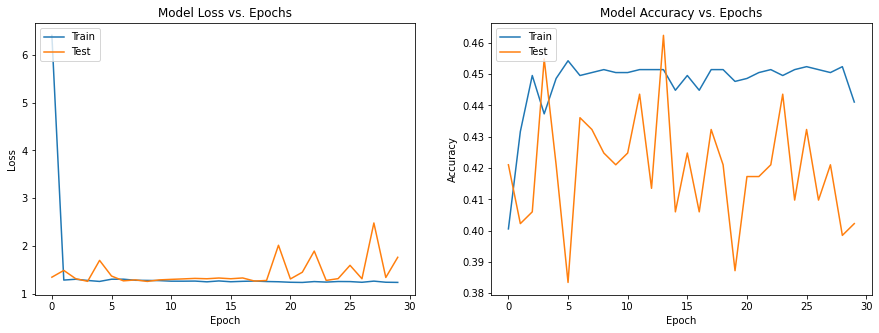

In [25]:
# visualize training - only wings (with preprocessing)
plt.figure(figsize=(15,5))

# plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_wings_pp.history['loss'])
plt.plot(history_wings_pp.history['val_loss'])
plt.title('Model Loss vs. Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history_wings_pp.history['accuracy'])
plt.plot(history_wings_pp.history['val_accuracy'])
plt.title('Model Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# show plot
plt.savefig('gdrive/My Drive/MosquitoNet/figures/wings_pp.png')
plt.show()

In [30]:
# training parameters
BATCH_SIZE = 32
STEPS_PER_EPOCH = np.ceil(len(x_train) / BATCH_SIZE)
EPOCHS = 30

# create generators
train_generator = train_datagen.flow(x_train, y_train_onehot, batch_size=BATCH_SIZE)
test_generator = test_datagen.flow(x_test, y_test_onehot, batch_size=BATCH_SIZE)

# train model - only palps (with pre-processing)
history_palps_pp = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_generator,
    validation_steps=np.ceil(len(x_test)/BATCH_SIZE)
)

Epoch 1/30
34/34 [==============================] - 15s 436ms/step - loss: 3.6391 - accuracy: 0.4232 - val_loss: 6.8285 - val_accuracy: 0.4211
Epoch 2/30
34/34 [==============================] - 15s 428ms/step - loss: 1.2863 - accuracy: 0.4467 - val_loss: 1.7893 - val_accuracy: 0.2857
Epoch 3/30
34/34 [==============================] - 15s 427ms/step - loss: 1.2770 - accuracy: 0.4402 - val_loss: 1.2831 - val_accuracy: 0.4135
Epoch 4/30
34/34 [==============================] - 14s 426ms/step - loss: 1.2799 - accuracy: 0.4477 - val_loss: 1.3024 - val_accuracy: 0.4549
Epoch 5/30
34/34 [==============================] - 15s 428ms/step - loss: 1.2786 - accuracy: 0.4496 - val_loss: 1.2819 - val_accuracy: 0.4060
Epoch 6/30
34/34 [==============================] - 14s 423ms/step - loss: 1.2808 - accuracy: 0.4515 - val_loss: 1.2517 - val_accuracy: 0.4549
Epoch 7/30
34/34 [==============================] - 14s 422ms/step - loss: 1.2716 - accuracy: 0.4515 - val_loss: 1.3142 - val_accuracy: 0.4060

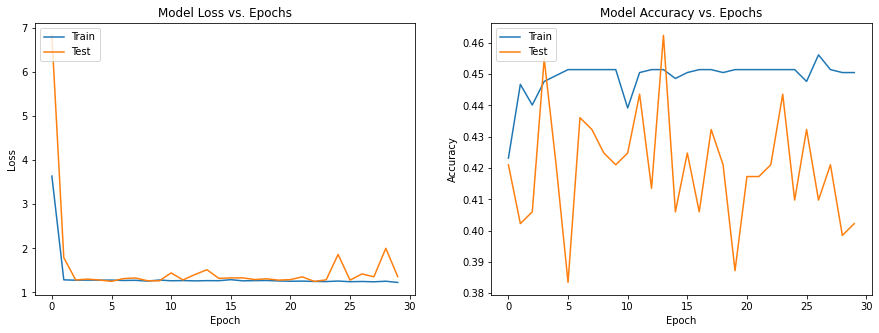

In [31]:
# visualize training - only palps (with preprocessing)
plt.figure(figsize=(15,5))

# plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_palps_pp.history['loss'])
plt.plot(history_palps_pp.history['val_loss'])
plt.title('Model Loss vs. Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history_palps_pp.history['accuracy'])
plt.plot(history_wings_pp.history['val_accuracy'])
plt.title('Model Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# show plot
plt.savefig('gdrive/My Drive/MosquitoNet/figures/palps_pp.png')
plt.show()